In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import joblib

from astropy.io import fits
from functools import reduce
from astropy.table import Table

sys.path.append('../../methods_code_Nresol/')
sys.path.append('../../utils/')
import astro_cuts
import importlib
import spec_utils

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
fname = 'lsd_scripts/spectrain_2_11_r50.fits'
df_allspec = spec_utils.convert_to_dataframe_specmatched(fname)
df_goodspec = spec_utils.return_goodspec(df_allspec)

/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:36: RuntimeWarning: divide by zero encountered in true_divide
  df['reduced_chisq'] = df['chisq'].to_numpy() * n_passbands / (n_passbands - 4)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:40: RuntimeWarning: divide by zero encountered in power
  sdss_flux_sig = np.power(np.array(dat['sdss_dr14_starsweep.psfflux_ivar']), -0.5)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: divide by zero encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]), 0.0, np.inf)
/n/holylfs05/LABS/finkbeiner_lab/Everyone/highlat/notebooks_main1/spectra_matched/spec_utils.py:42: RuntimeWarning: invalid value encountered in log10
  df['sdss.pmag_'+b] = 22.5 - 2.5*np.clip(np.log10(np.array(dat['sdss_dr14_starsweep.psfflux'])[:, ib]),

Number of objects before / after 596315 210713
c1 = 0.873, c2 = 0.995, c3 = 0.445
Fraction left = 0.353


### Part1: Making mag dbn plots

In [4]:
plt.rcParams.update({'font.family':'serif', 'font.size': 12})

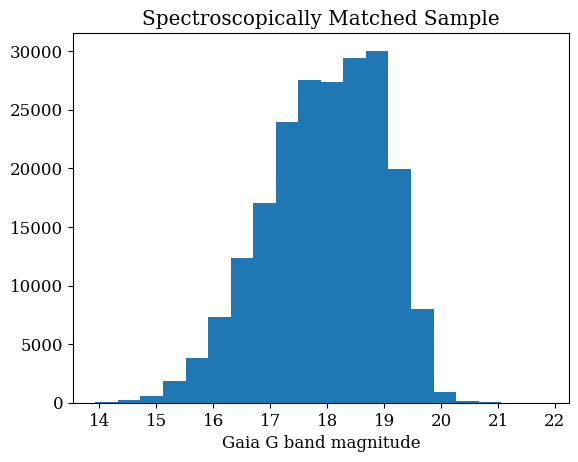

In [5]:
plt.figure()
plt.hist(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy(), bins=20)
plt.title('Spectroscopically Matched Sample')
plt.xlabel('Gaia G band magnitude')
#plt.savefig('../../plots/mag_specmatched.pdf')
plt.show()

In [6]:
df_allcat = pd.read_pickle('../../notebooks_test/intermed/4_10/ngc50_100ksubsamp_edr3.pkl')

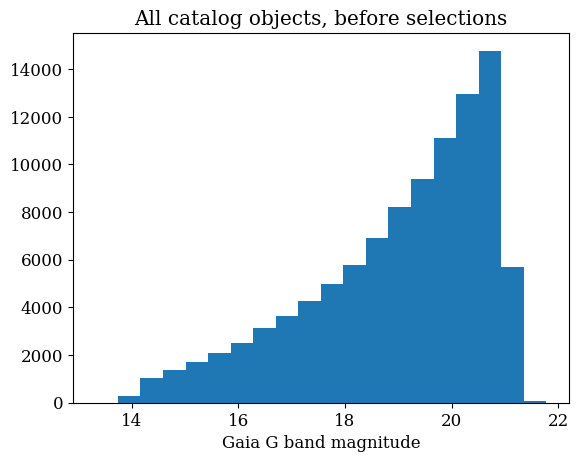

In [7]:
plt.figure()
plt.hist(df_allcat['gaia_edr3.phot_g_mean_mag'].to_numpy(), bins=20)
plt.title('All catalog objects, before selections')
plt.xlabel('Gaia G band magnitude')
#plt.savefig('../../plots/mag_allcat_nocuts.pdf')
plt.show()

In [8]:
nbtest_dir = '../../notebooks_test/'

def combine_cuts(df_input, cuts_list):
    cutfuncs = [getattr(astro_cuts, ctup[0]) for ctup in cuts_list]
    masklist = []
    for c, ctup in enumerate(cuts_list):
        if len(ctup)==1:
            masklist.append(cutfuncs[c](df_input))
        else:
            masklist.append(cutfuncs[c](df_input, **ctup[1]))
        print('Cut{} {} {}'.format(c, np.sum(masklist[c]), np.sum(masklist[c])/len(masklist[c])))
    final_cut = reduce(np.logical_and, masklist) #intersection of all cuts
    print('Effective Cut = {:.3f}'.format(np.sum(final_cut)/len(final_cut)))
    return final_cut

In [10]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_balanced_new.joblib')

cuts_list = [('distmod_median_cut_corr', {'minpc': 400}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut_limiting', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_goodspec, cuts_list) #intersection of all cuts
df16a = df_goodspec.iloc[final_cut, :]
spec_utils.print_obj_distribution(df16a['sdss_dr17_specobj.CLASS'])

Cut0 205550 0.9754974776117278
Cut1 200235 0.9502735948897315
Cut2 172977 0.8209128055696611
Cut3 210106 0.997119304456773
Cut4 173743 0.8245480819882969
Cut5 156011 0.740395704109381
Effective Cut = 0.659
Number of Stars = 138797, Fraction(%) = 99.9302, Ratio(obj:star)*100 = 100
Number of Galaxies = 51, Fraction(%) = 0.0367, Ratio(obj:star)*100 = 0.0367
Number of QSOs = 46, Fraction(%) = 0.0331, Ratio(obj:star)*100 = 0.0331


In [11]:
final_cutallcat = combine_cuts(df_allcat, cuts_list) #intersection of all cuts
dfpostcuts = df_allcat.iloc[final_cutallcat, :]

Cut0 91157 0.91157
Cut1 96690 0.9669
Cut2 81982 0.81982
Cut3 89686 0.89686
Cut4 97761 0.97761
Cut5 76250 0.7625
Effective Cut = 0.574


In [13]:
#without plx
cuts_list_alt = [('distmod_median_cut_corr', {'minpc': 400}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut_limiting', {'model': wisemodel}),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]
final_cutalt = combine_cuts(df_allcat, cuts_list_alt) #intersection of all cuts

Cut0 91157 0.91157
Cut1 96690 0.9669
Cut2 81982 0.81982
Cut3 97761 0.97761
Cut4 76250 0.7625
Effective Cut = 0.586


NameError: name 'final_cut_alt' is not defined

In [14]:
dfpostcuts_alt = df_allcat.iloc[final_cutalt, :]

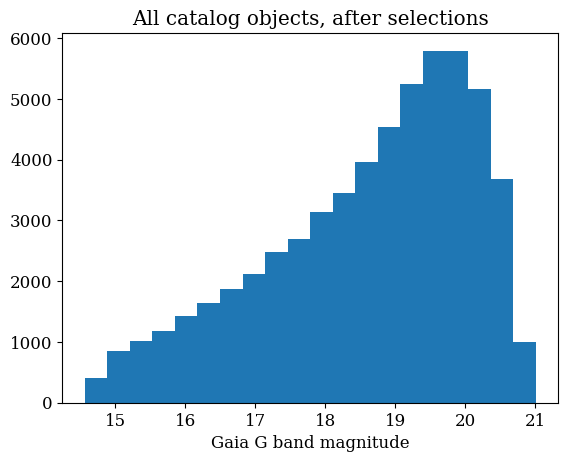

In [12]:
plt.figure()
plt.hist(dfpostcuts['gaia_edr3.phot_g_mean_mag'].to_numpy(), bins=20)
plt.title('All catalog objects, after selections')
plt.xlabel('Gaia G band magnitude')
plt.savefig('../../plots/mag_allcat_postcuts.pdf')
plt.show()

### Part 2: What if the objects were all as noisy as the set of objects in the full catalog in the 'x'th magnitude bin?
#### make sure you only consider the objects that satisfy the cuts that the sdss svm cut is actually used on

In [5]:
df_allcat = pd.read_pickle('../../notebooks_test/intermed/4_10/ngc50_100ksubsamp_edr3.pkl')

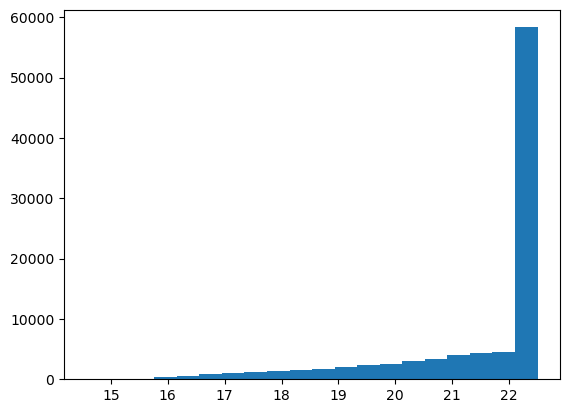

In [8]:
plt.figure()
plt.hist(df_allcat['sdss.pmag_u'].to_numpy(), bins=20)
plt.show()

In [5]:
df_allcat['sdss.u-g'] = df_allcat['sdss.pmag_u'].to_numpy() - df_allcat['sdss.pmag_g'].to_numpy()
df_allcat['sdss.g-r'] = df_allcat['sdss.pmag_g'].to_numpy() - df_allcat['sdss.pmag_r'].to_numpy()

In [6]:
wisemodel = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
smodel = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

def combine_cuts(df_input, cuts_list):
    cutfuncs = [getattr(astro_cuts, ctup[0]) for ctup in cuts_list]
    masklist = []
    for c, ctup in enumerate(cuts_list):
        if len(ctup)==1:
            masklist.append(cutfuncs[c](df_input))
        else:
            masklist.append(cutfuncs[c](df_input, **ctup[1]))
        print('Cut{} {} {}'.format(c, np.sum(masklist[c]), np.sum(masklist[c])/len(masklist[c])))
    final_cut = reduce(np.logical_and, masklist) #intersection of all cuts
    print('Effective Cut = {:.3f}'.format(np.sum(final_cut)/len(final_cut)))
    return final_cut

cuts_list = [('distmod_median_cut', {'mindm': 8}), ('dm_sigma_cut', {'maxsig': 1.5}), 
             ('wise_svmnondetectioncombinedcut', {'model': wisemodel}), ('parallax_nan_edr3',),
             ('sdss_uvcut', {'model': smodel}), ('bayestar_chisq', {'maxchisq': 3.0})]

final_cut = combine_cuts(df_allcat, cuts_list) #intersection of all cuts
dfpostcuts = df_allcat.iloc[final_cut, :]

Cut0 95559 0.95559
Cut1 96690 0.9669
Cut2 95688 0.95688
Cut3 89686 0.89686
Cut4 98175 0.98175
Cut5 76250 0.7625
Effective Cut = 0.654


In [94]:
np.isnan(df_allcat['mag_r'].to_numpy()).sum()/len(df_allcat), np.isnan(dfpostcuts['mag_r'].to_numpy()).sum()/len(dfpostcuts)

(0.01362, 4.589752612334195e-05)

In [95]:
np.isnan(df_allcat['mag_i'].to_numpy()).sum()/len(df_allcat), np.isnan(dfpostcuts['mag_i'].to_numpy()).sum()/len(dfpostcuts)

(0.01941, 0.00010709422762113121)

In [96]:
np.isnan(df_allcat['mag_z'].to_numpy()).sum()/len(df_allcat), np.isnan(dfpostcuts['mag_z'].to_numpy()).sum()/len(dfpostcuts)

(0.0071, 3.059835074889464e-05)

In [98]:
(df_allcat['allwise.w1mpro'].to_numpy()==0).sum()/len(df_allcat), (dfpostcuts['allwise.w1mpro'].to_numpy()==0).sum()/len(dfpostcuts)

(0.35646, 0.2963297278276701)

In [105]:
np.isnan(df_allcat['sdss.pmag_u'].to_numpy()).sum()/len(df_allcat), np.isnan(dfpostcuts['sdss.pmag_u'].to_numpy()).sum()/len(dfpostcuts)

(0.07025, 0.05397549072105014)

In [106]:
np.isnan(df_allcat['sdss.pmag_g'].to_numpy()).sum()/len(df_allcat), np.isnan(dfpostcuts['sdss.pmag_g'].to_numpy()).sum()/len(dfpostcuts)

(0.00022, 7.649587687223658e-05)

In [10]:
np.median(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy()[~np.isnan(df_goodspec['gaia_edr3.phot_g_mean_mag'].to_numpy())])

18.036919

In [11]:
np.median(df_allcat['gaia_edr3.phot_g_mean_mag'].to_numpy()[~np.isnan(df_allcat['gaia_edr3.phot_g_mean_mag'].to_numpy())])

19.432806

### 2.1 WISE
I only applied the cut that is applied before the cut is applied and not for when the cut was trained, i.e. the df_goodpsec here is the FULL set, and not the subset used to train the cut.

In [107]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [120]:
def applied_pan_wise_cuts(df_input):
    mask = (df_input['allwise.w1mpro'].to_numpy() != 0) * (~np.isnan(df_input['r-i'].to_numpy())) * (~np.isnan(df_input['z-W1'].to_numpy()))
    return mask

def repackage_df(df_input, features, noise):
    xpts = df_input[features].to_numpy()
    ypts = df_input['label'].to_numpy()
    if np.allclose(noise, np.zeros(2)):
        return xpts, ypts
    else:
        rng = np.random.default_rng()
        noisyx = rng.normal(loc=xpts, scale=noise)
        return noisyx, ypts
    
WISEMODEL = joblib.load('models/svm_panstarrs_quasarsep_balanced.joblib')
def make_wiseccplot(train_x, train_y):
    w = WISEMODEL.coef_[0]
    b = WISEMODEL.intercept_[0]
    x_points = np.linspace(np.min(train_x[:, 0]), np.max(train_x[:, 0]), num=50)
    y_points = -(w[0] / w[1]) * x_points - b / w[1]
    y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
    # Plotting a red hyperplane

    h=0.05
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = WISEMODEL.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.scatter(train_x[train_y==1, 0], train_x[train_y==1, 1], label='Star', s=1, alpha=0.5)
    plt.scatter(train_x[train_y==0, 0], train_x[train_y==0, 1], label='Gal / QSO', s=1, alpha=0.5)
    plt.plot(x_points, y_points, c='r')
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)

    plt.xlabel('r-i')
    plt.ylabel('z-W1')
    plt.xlim(-0.7, 2)
    plt.ylim(-1, 6)
    plt.legend()
    plt.show()
    
    y_pred = WISEMODEL.predict(train_x)
    cm = confusion_matrix(train_y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax, xticklabels=['ExGal', 'Star'], yticklabels=['ExGal', 'Star'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.invert_yaxis()
    plt.show()
    return

In [121]:
wisecut = applied_pan_wise_cuts(df_goodspec)
dfwisepreapp = df_goodspec.iloc[wisecut, :]
xpts, ypts = repackage_df(dfwisepreapp, ['r-i', 'z-W1'], noise=np.zeros(2))

-22.80264663696289 17.5871639251709


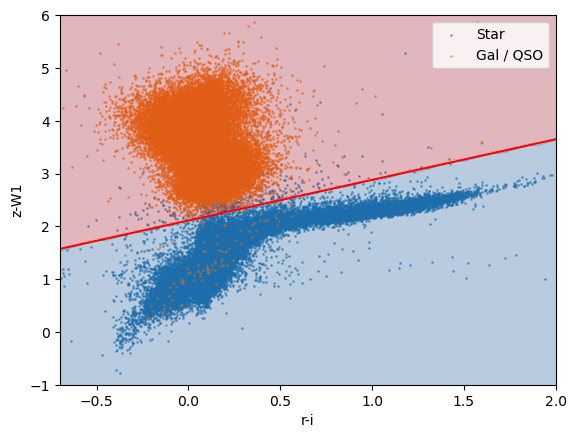

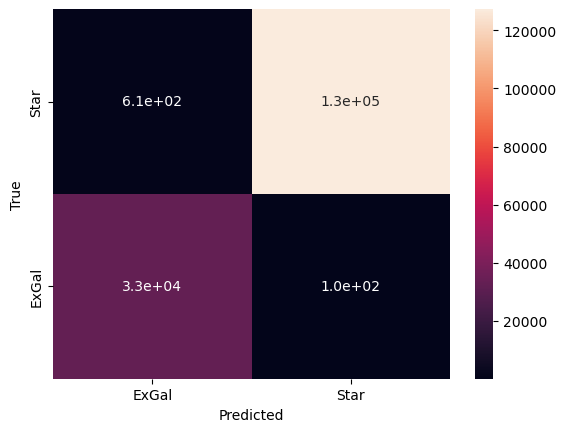

In [122]:
make_wiseccplot(xpts, ypts)

In [123]:
allcat_err_ri = np.sqrt(df_allcat['mag_err_r']**2 + df_allcat['mag_err_i']**2)
allcat_err_zW1 = np.sqrt(df_allcat['mag_err_z']**2 + df_allcat['allwise.w1sigmpro']**2)
allcatmags = df_allcat['gaia_edr3.phot_g_mean_mag'].to_numpy()

#### 18-19

In [ ]:
magmask = (allcatmags>=18)*(allcatmags<19)*(~np.isnan(df_allcat['r-i'].to_numpy()))*(~np.isnan(df_allcat['z-W1'].to_numpy()))
med_err_ri = np.median(allcat_err_ri[magmask])
med_err_zW1 = np.median(allcat_err_zW1[magmask])

In [125]:
med_err_ri, med_err_zW1

(0.030341329, 0.04370305)

In [126]:
wisecut = applied_pan_wise_cuts(df_goodspec)
dfwisepreapp = df_goodspec.iloc[wisecut, :]
xpts, ypts = repackage_df(dfwisepreapp, ['r-i', 'z-W1'], noise=np.array([med_err_ri, med_err_zW1]))

-22.781749984438367 17.583275635005332


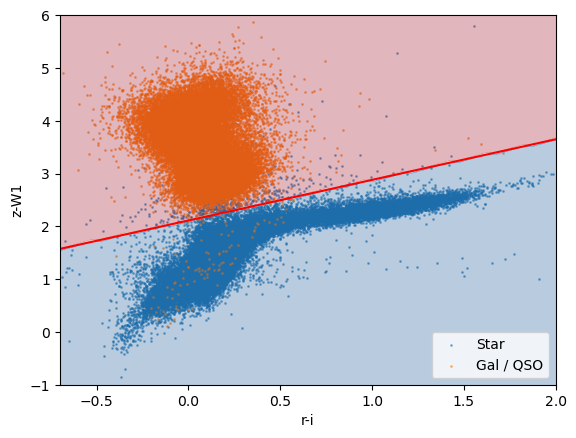

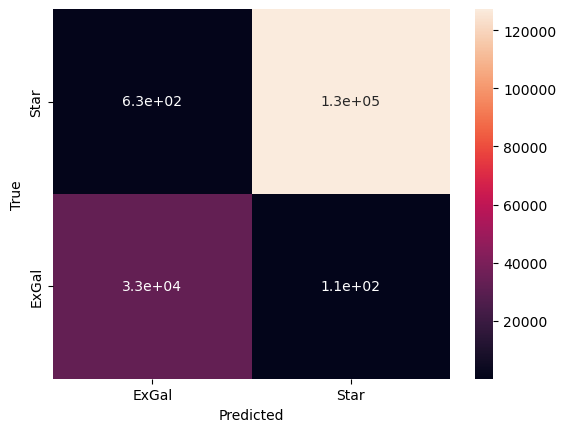

In [127]:
make_wiseccplot(xpts, ypts)

#### 19-20

In [128]:
magmask = (allcatmags>=19)*(allcatmags<20)*(~np.isnan(df_allcat['r-i'].to_numpy()))*(~np.isnan(df_allcat['z-W1'].to_numpy()))
med_err_ri = np.median(allcat_err_ri[magmask])
med_err_zW1 = np.median(allcat_err_zW1[magmask])

In [129]:
med_err_ri, med_err_zW1

(0.034786694, 0.047290698)

In [130]:
wisecut = applied_pan_wise_cuts(df_goodspec)
dfwisepreapp = df_goodspec.iloc[wisecut, :]
xpts, ypts = repackage_df(dfwisepreapp, ['r-i', 'z-W1'], noise=np.array([med_err_ri, med_err_zW1]))

-22.813653869583344 17.56443725425003


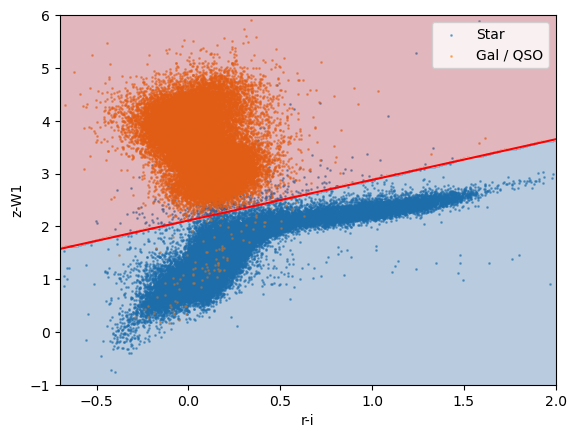

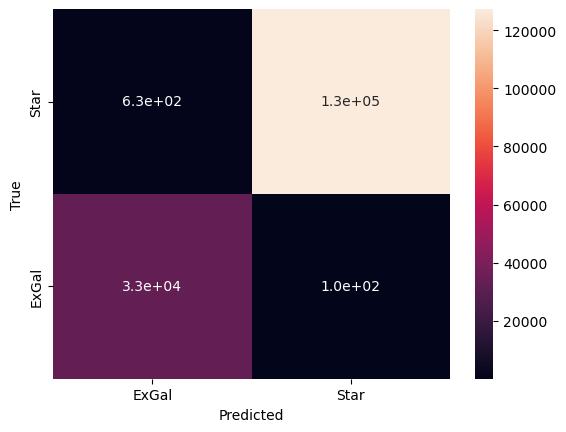

In [131]:
make_wiseccplot(xpts, ypts)

#### 20-21

In [132]:
magmask = (allcatmags>=20)*(allcatmags<21)*(~np.isnan(df_allcat['r-i'].to_numpy()))*(~np.isnan(df_allcat['z-W1'].to_numpy()))
med_err_ri = np.median(allcat_err_ri[magmask])
med_err_zW1 = np.median(allcat_err_zW1[magmask])

In [133]:
med_err_ri, med_err_zW1

(0.05243288, 0.057973847)

In [134]:
wisecut = applied_pan_wise_cuts(df_goodspec)
dfwisepreapp = df_goodspec.iloc[wisecut, :]
xpts, ypts = repackage_df(dfwisepreapp, ['r-i', 'z-W1'], noise=np.array([med_err_ri, med_err_zW1]))

-22.80008853584607 17.60933210350542


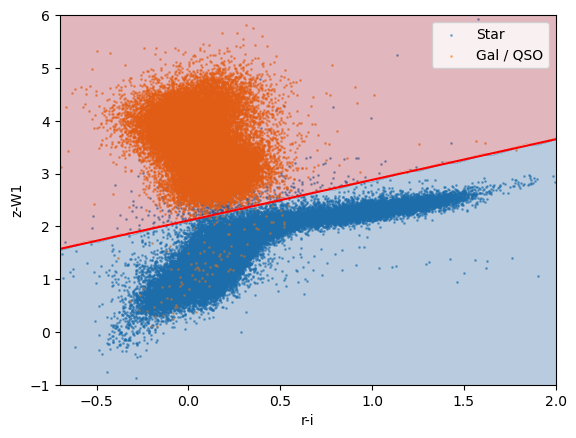

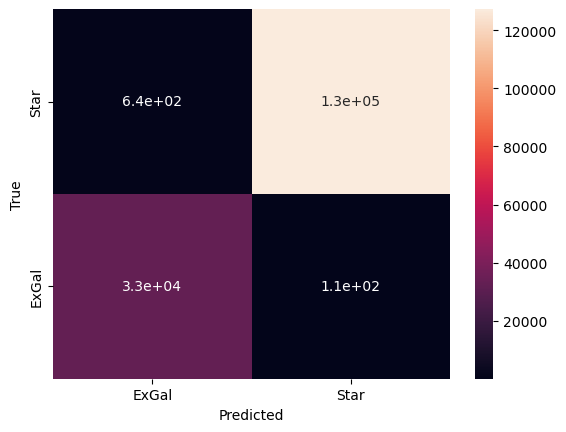

In [135]:
make_wiseccplot(xpts, ypts)

#### >21

In [136]:
magmask = (allcatmags>21)*(~np.isnan(df_allcat['r-i'].to_numpy()))*(~np.isnan(df_allcat['z-W1'].to_numpy()))
med_err_ri = np.median(allcat_err_ri[magmask])
med_err_zW1 = np.median(allcat_err_zW1[magmask])

In [137]:
med_err_ri, med_err_zW1

(0.07450559, 0.06905759)

In [138]:
wisecut = applied_pan_wise_cuts(df_goodspec)
dfwisepreapp = df_goodspec.iloc[wisecut, :]
xpts, ypts = repackage_df(dfwisepreapp, ['r-i', 'z-W1'], noise=np.array([med_err_ri, med_err_zW1]))

-22.715409651024512 17.622823171815526


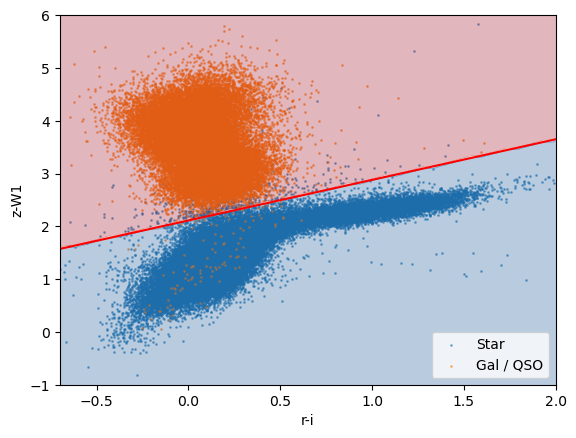

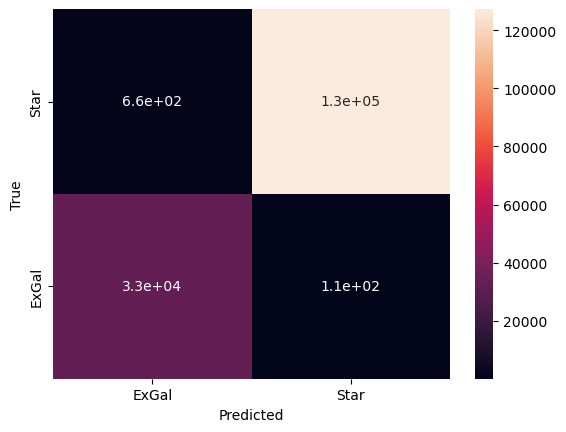

In [139]:
make_wiseccplot(xpts, ypts)

### 2.2 SDSS
I only applied the cut that is applied before the cut is applied and not for when the cut was trained, i.e. the df_goodpsec here is the FULL set, and not the subset used to train the cut.

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
df_goodspec.loc[:, 'sdss.u-g'] = df_goodspec['sdss.pmag_u'].to_numpy() - df_goodspec['sdss.pmag_g'].to_numpy()
df_goodspec.loc[:, 'sdss.g-r'] = df_goodspec['sdss.pmag_g'].to_numpy() - df_goodspec['sdss.pmag_r'].to_numpy()

/n/home02/nmudur/.conda/envs/pytorch_env2/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/n/home02/nmudur/.conda/envs/pytorch_env2/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [9]:
def applied_pan_sdss_cuts(df_input):
    detected_all = ~(np.isnan(df_input['sdss.pmag_u'].to_numpy()) + np.isnan(df_input['sdss.pmag_g'].to_numpy()) + np.isnan(
        df_input['sdss.pmag_r'].to_numpy()))
    sdssmagcols = ['sdss.pmag_u', 'sdss.pmag_g', 'sdss.pmag_r']

    # ugr errs < 0.2
    sdss_errcols = df_input.columns[[c.startswith('sdss.pmag_err_') for c in df_input.columns]]
    sdss_pmag_err = df_input[sdss_errcols].to_numpy()
    detected_all *= np.all(sdss_pmag_err[:, :3] < 0.2, axis=1)

    # no negative errors
    detected_all *= ~np.any(sdss_pmag_err[:, :3] < 0, axis=1)

    # saturated on the faint end
    detected_all *= ~np.any(df_input[sdssmagcols].to_numpy() == 22.5, axis=1)  # nothing should have exactly 22.5

    mask = detected_all * (~np.isnan(df_input['sdss.u-g'].to_numpy())) * (~np.isnan(df_input['sdss.g-r'].to_numpy()))
    return mask

def repackage_df(df_input, features, noise):
    xpts = df_input[features].to_numpy()
    ypts = df_input['label'].to_numpy()
    if np.allclose(noise, np.zeros(2)):
        return xpts, ypts
    else:
        rng = np.random.default_rng()
        noisyx = rng.normal(loc=xpts, scale=noise)
        return noisyx, ypts
    
SDSSMODEL = joblib.load('models/svm_sdss_quasarsep_unbalanced.joblib')

def make_sdssccplot(train_x, train_y):
    h=0.05
    x_min, x_max = train_x[:, 0].min() - 1, train_x[:, 0].max() + 1
    y_min, y_max = train_x[:, 1].min() - 1, train_x[:, 1].max() + 1
    print(x_min, x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = SDSSMODEL.predict(np.vstack([xx.ravel(), yy.ravel()]).T)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.scatter(train_x[train_y==1, 0], train_x[train_y==1, 1], label='Star', s=1, alpha=0.1)
    plt.scatter(train_x[train_y==0, 0], train_x[train_y==0, 1], label='Gal / QSO', s=1, alpha=0.1, c='r')
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)

    plt.xlabel('u-g')
    plt.ylabel('g-r')
    plt.xlim(-2, 4)
    plt.ylim(-2, 4)
    plt.legend()
    plt.show()
    
    y_pred = SDSSMODEL.predict(train_x)
    cm = confusion_matrix(train_y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax, xticklabels=['ExGal', 'Star'], yticklabels=['ExGal', 'Star'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.invert_yaxis()
    plt.show()
    return

In [10]:
sdsscut = applied_pan_sdss_cuts(df_goodspec)
dfsdsspreapp = df_goodspec.iloc[sdsscut, :]
xpts, ypts = repackage_df(dfsdsspreapp, ['sdss.u-g', 'sdss.g-r'], noise=np.zeros(2))

-5.061674118041992 5.599302291870117


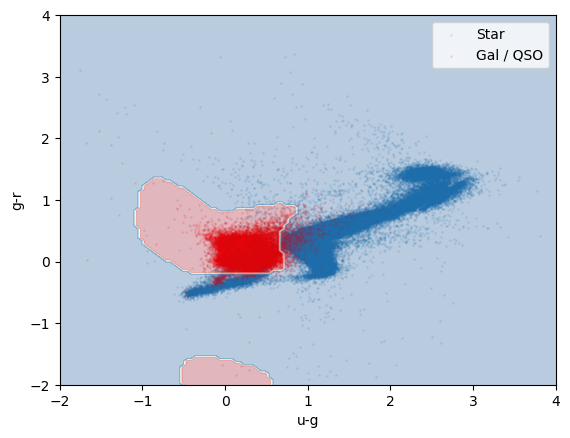

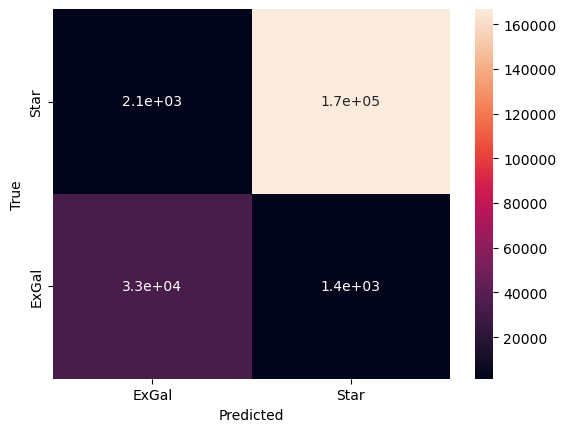

In [11]:
make_sdssccplot(xpts, ypts)

In [12]:
allcat_err_ug = np.sqrt(df_allcat['sdss.pmag_err_u']**2 + df_allcat['sdss.pmag_err_g']**2)
allcat_err_gr = np.sqrt(df_allcat['sdss.pmag_err_g']**2 + df_allcat['sdss.pmag_err_r']**2)
allcatmags = df_allcat['gaia_edr3.phot_g_mean_mag'].to_numpy()

#### 18-19

In [13]:
magmask = (allcatmags>=18)*(allcatmags<19)*(~np.isnan(df_allcat['sdss.u-g'].to_numpy()))*(~np.isnan(df_allcat['sdss.g-r'].to_numpy()))
med_err_ug = np.median(allcat_err_ug[magmask])
med_err_gr = np.median(allcat_err_gr[magmask])

In [14]:
med_err_ug, med_err_gr

(0.2904035, 0.033234652)

In [15]:
sdsscut = applied_pan_sdss_cuts(df_goodspec)
dfsdsspreapp = df_goodspec.iloc[sdsscut, :]
xpts, ypts = repackage_df(dfsdsspreapp, ['sdss.u-g', 'sdss.g-r'], noise=np.array([med_err_ug, med_err_gr]))

In [16]:
np.isnan(dfsdsspreapp['sdss.pmag_r']).sum()

0

-4.74998673094687 5.649726808672449


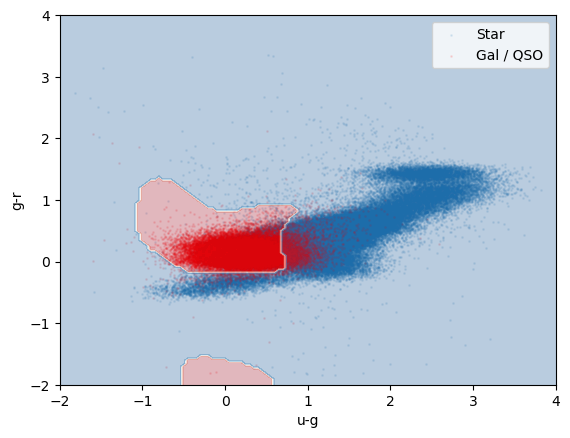

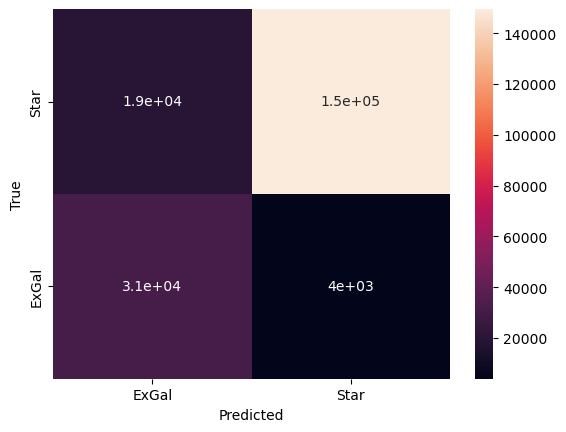

In [17]:
make_sdssccplot(xpts, ypts)

#### 19-20

In [18]:
magmask = (allcatmags>=19)*(allcatmags<20)*(~np.isnan(df_allcat['sdss.u-g'].to_numpy()))*(~np.isnan(df_allcat['sdss.g-r'].to_numpy()))
med_err_ug = np.median(allcat_err_ug[magmask])
med_err_gr = np.median(allcat_err_gr[magmask])

In [19]:
med_err_ug, med_err_gr

(0.7017073, 0.04987801)

In [20]:
sdsscut = applied_pan_sdss_cuts(df_goodspec)
dfsdsspreapp = df_goodspec.iloc[sdsscut, :]
xpts, ypts = repackage_df(dfsdsspreapp, ['sdss.u-g', 'sdss.g-r'], noise=np.array([med_err_ug, med_err_gr]))

In [21]:
np.isnan(dfsdsspreapp['sdss.pmag_r']).sum()

0

-5.422664443328472 6.144072029201096


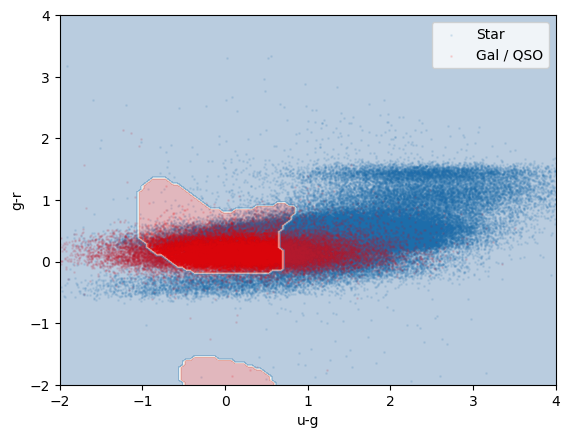

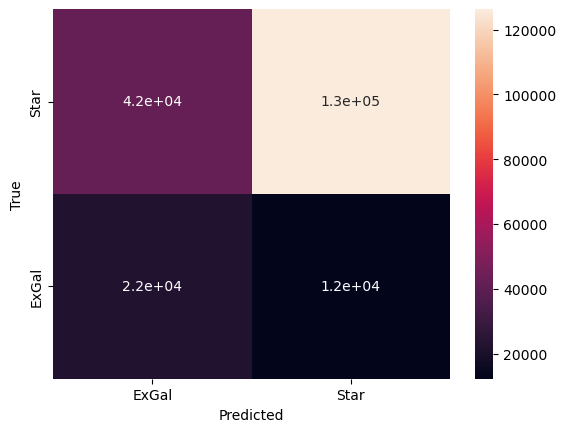

In [22]:
make_sdssccplot(xpts, ypts)

#### 20-21

In [23]:
magmask = (allcatmags>=20)*(allcatmags<21)*(~np.isnan(df_allcat['sdss.u-g'].to_numpy()))*(~np.isnan(df_allcat['sdss.g-r'].to_numpy()))
med_err_ug = np.median(allcat_err_ug[magmask])
med_err_gr = np.median(allcat_err_gr[magmask])

In [24]:
med_err_ug, med_err_gr

(1.2036035, 0.1083138)

In [25]:
sdsscut = applied_pan_sdss_cuts(df_goodspec)
dfsdsspreapp = df_goodspec.iloc[sdsscut, :]
xpts, ypts = repackage_df(dfsdsspreapp, ['sdss.u-g', 'sdss.g-r'], noise=np.array([med_err_ug, med_err_gr]))

In [26]:
np.isnan(dfsdsspreapp['sdss.pmag_r']).sum()

0

-6.193116074953708 7.835595757218172


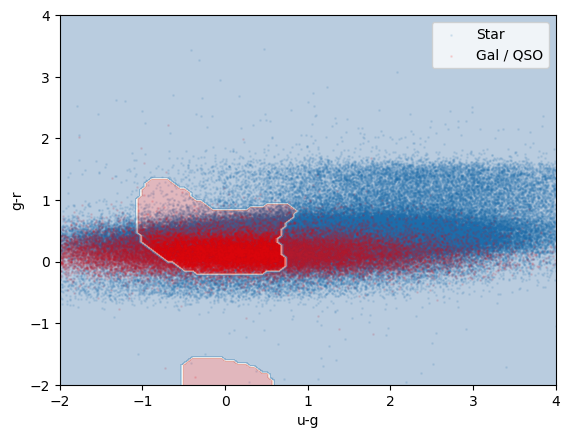

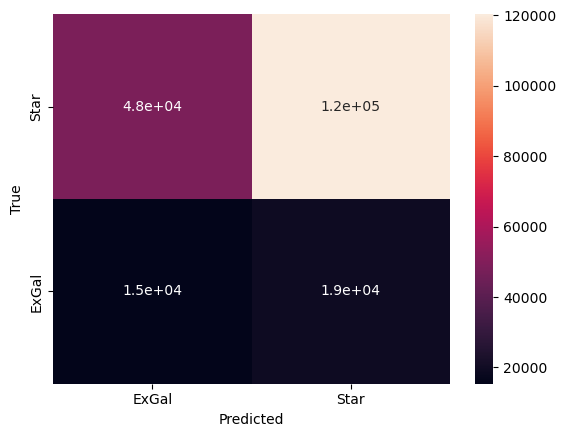

In [27]:
make_sdssccplot(xpts, ypts)

#### >21

In [28]:
magmask = (allcatmags>21)*(~np.isnan(df_allcat['sdss.u-g'].to_numpy()))*(~np.isnan(df_allcat['sdss.g-r'].to_numpy()))
med_err_ug = np.median(allcat_err_ug[magmask])
med_err_gr = np.median(allcat_err_gr[magmask])

In [29]:
med_err_ug, med_err_gr

(1.3995633, 0.16867873)

In [30]:
sdsscut = applied_pan_sdss_cuts(df_goodspec)
dfsdsspreapp = df_goodspec.iloc[sdsscut, :]
xpts, ypts = repackage_df(dfsdsspreapp, ['sdss.u-g', 'sdss.g-r'], noise=np.array([med_err_ug, med_err_gr]))

In [31]:
np.isnan(dfsdsspreapp['sdss.pmag_r']).sum()

0

-6.8796654932919905 8.537426832942327


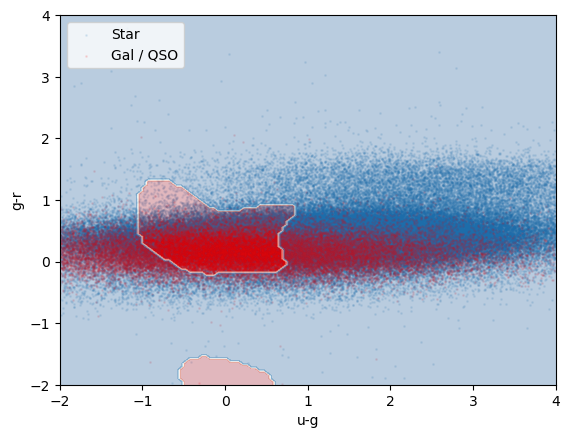

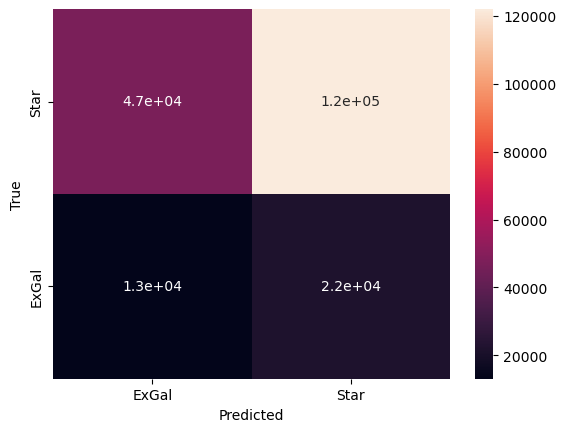

In [32]:
make_sdssccplot(xpts, ypts)

In [8]:
df_goodspec.columns.tolist()

['_id',
 'ra',
 'dec',
 'gaia_id',
 'l',
 'b',
 'plx',
 'plx_err',
 'chisq',
 'gaia_edr3.source_id',
 'gaia_edr3.l',
 'gaia_edr3.b',
 'gaia_edr3.pm',
 'gaia_edr3.pmra',
 'gaia_edr3.pmra_error',
 'gaia_edr3.pmdec',
 'gaia_edr3.pmdec_error',
 'gaia_edr3.parallax',
 'gaia_edr3.parallax_error',
 'gaia_edr3.parallax_over_error',
 'gaia_edr3.astrometric_n_good_obs_al',
 'gaia_edr3.astrometric_chi2_al',
 'gaia_edr3.astrometric_excess_noise',
 'gaia_edr3.visibility_periods_used',
 'gaia_edr3.phot_g_mean_mag',
 'gaia_edr3.bp_rp',
 'gaia_edr3.ruwe',
 'gaia_dr2_source.l',
 'gaia_dr2_source.b',
 'gaia_dr2_source.ra',
 'gaia_dr2_source.dec',
 'gaia_dr2_source.ra_error',
 'gaia_dr2_source.dec_error',
 'gaia_dr2_source.solution_id',
 'gaia_dr2_source.parallax',
 'gaia_dr2_source.parallax_error',
 'gaia_dr2_source.visibility_periods_used',
 'gaia_dr2_source.astrometric_chi2_al',
 'gaia_dr2_source.astrometric_n_good_obs_al',
 'gaia_dr2_source.astrometric_excess_noise',
 'gaia_dr2_source.phot_g_mean_mag

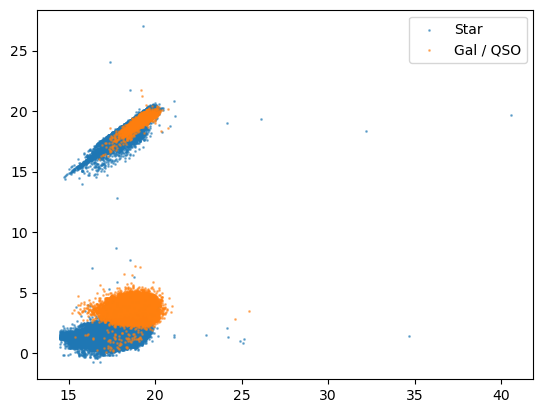

In [22]:
train_y = df_goodspec['label'].to_numpy()
plt.figure()
plt.scatter(df_goodspec.loc[train_y==1, 'mag_r'], df_goodspec.loc[train_y==1, 'z-W1'], label='Star', s=1, alpha=0.5)
plt.scatter(df_goodspec.loc[train_y==0, 'mag_r'], df_goodspec.loc[train_y==0, 'z-W1'], label='Gal / QSO', s=1, alpha=0.5)
#plt.xlim(-0.7, 2)
#plt.ylim(-1, 6)
plt.legend()
plt.show()